In [1]:
import sys

from random import choices
from collections import deque

from IPython import display
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

In [219]:
class DQN():
    '''
    Deep Q-Learning Network
    
    
    Vocab:
    ------
    
    observation: immediate info provided by environment
    history: accumulation of state,action and observation
    state: F(history) to provide always same input length
    
    '''
    def __init__(self,env,hyperparams=None):
        
        if hyperparams is None:
            hyperparams = {}
        
        self.nactions = env.action_space.n
        
        self.epsilon = hyperparams.get('epsilon',0.5) #Exploration probability
        self.epsilon_min = hyperparams.get('epsilon_min',0.1)
        self.alpha = hyperparams.get('alpha',0.01) #Learning rate
        self.gamma = hyperparams.get('gamma',1) #Discount rate
        
        self.nframes = hyperparams.get('nframes', 4)
        
        self.replay_capacity = int(hyperparams.get('N',10e2))
        self.replay_memory = [] # Stores  {self.replay_capacity}x(state,action,reward,next_state)
        
        self.q = self._initialize_cnn()
        self.batch_size = hyperparams.get('batch_size',32)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.q.parameters(), lr=0.001, momentum=0.9)
        
        self.history = [] # Stores {self.nframes} most recent observations 
        

    
    def _initialize_cnn(self):
        cnn = Net(channels_in = self.nframes, channels_out = self.nactions)
        return cnn
    
    def memorize(self, action, reward, observation, done):
        
        phi = _phi(self.history, nframes = self.nframes)
        self.history.append(observation)
        next_phi = _phi(self.history, nframes = self.nframes)      
        self.history = self.history[-10*self.nframes:] # 10 is simply an arbitrary history factor for debugging
        
        if (len(self.history) > self.nframes): 
            self.replay_memory.append([phi,
                                       action,
                                       reward,
                                       next_phi,
                                       done])
        
        self.replay_memory = self.replay_memory[-self.replay_capacity:]     
    
    def act(self):
        '''Epsilon-greedy policy
        '''
        
        if (len(self.history) >= self.nframes):
            state = _phi(self.history, nframes = self.nframes)

            if np.random.uniform(0,1)<self.epsilon:
                action = int(np.random.choice(self.nactions))
            else:
                with torch.no_grad():
                    action = self.q(torch.unsqueeze(state, 0)).argmax().item()
                    
        else:
            action = int(np.random.choice(self.nactions))
            
        return action
    
    def learn(self):
        
        if (len(self.replay_memory) >= self.batch_size):
            
            self.optimizer.zero_grad()
            samples = choices(self.replay_memory, k = self.batch_size)

            for sample in samples:
                state, action, reward, next_state, done = sample
                q_val = self.q(torch.unsqueeze(state, 0))
                with torch.no_grad():
                    target = self.q(torch.unsqueeze(state, 0))

                    if done:
                        target[0, action] = reward
                    else:
                        q_max = self.q(torch.unsqueeze(next_state, 0)).max().item()
                        target[0, action] = reward + self.gamma*q_max

                loss = self.criterion(q_val, target)
                loss.backward()

            self.optimizer.step()
        
    def _eval_q(self, numpy_state):
        '''
        For debugging only
        '''
        tensor_state = torch.unsqueeze(torch.from_numpy(numpy_state).float(), 0)
        with torch.no_grad():
            result = self.q(tensor_state)
        return result.detach().numpy()
    
    def reset(self):
        pass

In [220]:
class Net(nn.Module):
    def __init__(self, channels_in = 4, channels_out = 4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 17 * 17, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, channels_out)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 17 * 17)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



def _preprocess_frame(frame):
    '''
    Takes RGB image and returns cnn input.
    
    Params:
    -------
    frame: np.array, size: (210, 160, 3)
    
    Returns:
    --------
    np.array, size: (80,80)
    
    '''
    greyscale = np.dot(frame[...,:3], [0.2989, 0.5870, 0.1140]) #(210,160,3) -> (210,160)
    #Hard coded for breakout
    downsampled = greyscale[::2,::2] #(210,160) -> (105,80)
    squared = downsampled[17:97:,] #(105,80) -> (80,80) , Includes the full 'play area'
    
    return squared

def _phi(history, nframes = 4):
        '''Extracts current state from learned history
        '''
        frames = history[-nframes:]
        state = torch.tensor([_preprocess_frame(frame) for frame in frames]).float()
        return state


In [221]:
def train_dqn(agent,env,episodes):
    
    metrics = []
    frames = []
    
    for episode in episodes:
        observation = env.reset()
        done = False
        agent.history.append(observation)
        action = agent.act()
        
        while not done:
            next_observation,done,reward,info = env.step(action)
            next_action = agent.act()
            agent.learn(observation,action,reward,next_observation)
            
            observation = next_observation
            action = next_action
            
            update_metrics(metrics)
            update_frames(frames)
            
    return metrics,frames
            

In [222]:
env = gym.make('Breakout-v0')

In [223]:
# Test init
agent = DQN(env, hyperparams = {'nframes':1, 'batch_size':10})

In [224]:
#Test memorize

train_frames = []
episodes = 2

for i in range(episodes):

    observation = env.reset()
    done=False
    agent.history.append(observation)
    counter = 0
    
       
    while not done:  
        action = agent.act()
        observation, reward, done, info = env.step(action)
        agent.memorize(action, reward, observation, done)  
        agent.learn()

        train_frames.append({
            'frame': env.render(mode='rgb_array'),
            'state': observation,
            'action': action,
            'reward': reward
            })
        
        if (counter%5 == 0):
            print('Episode {}, action {}'.format(i, counter))
        counter += 1



Episode 0, action 0
Episode 0, action 5
Episode 0, action 10
Episode 0, action 15
Episode 0, action 20
Episode 0, action 25
Episode 0, action 30
Episode 0, action 35
Episode 0, action 40
Episode 0, action 45
Episode 0, action 50
Episode 0, action 55
Episode 0, action 60
Episode 0, action 65
Episode 0, action 70
Episode 0, action 75
Episode 0, action 80
Episode 0, action 85
Episode 0, action 90
Episode 0, action 95
Episode 0, action 100
Episode 0, action 105
Episode 0, action 110
Episode 0, action 115
Episode 0, action 120
Episode 0, action 125
Episode 0, action 130
Episode 0, action 135
Episode 0, action 140
Episode 0, action 145
Episode 0, action 150
Episode 0, action 155
Episode 0, action 160
Episode 0, action 165
Episode 0, action 170
Episode 0, action 175
Episode 0, action 180
Episode 0, action 185
Episode 0, action 190
Episode 1, action 0
Episode 1, action 5
Episode 1, action 10
Episode 1, action 15
Episode 1, action 20
Episode 1, action 25
Episode 1, action 30
Episode 1, action 3

In [ ]:
img = plt.imshow(train_frames[0]) # only call this once
for frame in range train_frames[1:]:
    img.set_data(env.render(frame) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

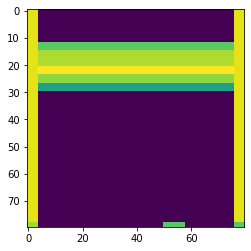

In [42]:
plt.imshow(obs_square)

In [20]:
from importlib import reload

reload(gym)

<module 'gym' (namespace)>

In [24]:
help(gym)

Help on package gym:

NAME
    gym

PACKAGE CONTENTS
    gym (package)
    setup
    tests (package)

FILE
    (built-in)


